# CS230 Project
# Deep Learning for VQA: Visual Question Answering

Stephanie Do <br> Alona King <br> Jennifer Villa

## Introduction

Our project explores the challenge of visual question answering (VQA) -- given an image and an open ended question concerning the image, build a model that returns a correct answer. This topic requires synthesizing both visual and language modalities, and combining the two to produce a natural language answer, making it more challenging than traditional image classification. VQA challenges researchers to create networks with a more sophisticated level of understanding that could ultimately be used to help robots or drones navigate their environment. These networks could also give visually impaired people a more rich description of a scene, or be used for better image or product search within a database.


## Dataset Description
For this project, we used the VQA v1.0 dataset, focusing on real images and open ended question answering. 

<br> The VQA 1.0 dataset is a collection of 82,783 MS COCO training images, 40,504 MS COCO validation images and 81,434 MS COCO testing images. Each image has 2-3 associated questions, for a total of 248,349 questions for training, 121,512 questions for validation and 244,302 questions for testing. Each question is associated with 10 ground truth answers, corresponding to the answers of 10 different human respondents when asked given the image-question pair. The dataset also includes a field identifying the most frequent ground truth answer of this set. <br>

<br> There is a VQA 2.0 dataset that has been released, which utilizes the same set of MSCOCO images, but has more questions per image (443K total questions, as compared to 248K). Due to constraints on training time, we decided to use the VQA 1.0 dataset because it is about half the size.  <br>

<br> Questions are broken into 3 sub-groups, based on their answer types: "yes/no", "number", and "other." The VQA challenge reports model accuracy for each sub-group, as well as an overall number. 

Examples from the VQA dataset: <br>
 <img src="./images_for_notebook/sample_questions.png">

## Loading and Manipulating the Dataset

First begin with the necessary import statements. Please note that you need Keras, Tensorflow, and h5py installed to run this code. 

In [1]:
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Merge, Input, Multiply, Concatenate, Lambda
from keras.layers.merge import Multiply
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import h5py
import os

import numpy as np
from keras.utils.np_utils import to_categorical
import json

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


Using TensorFlow backend.
/Users/jennifervilla/Documents/tensorflow_python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Download the Dataset
Rather than work off of the raw VQA v1.0 dataset, we used a preprocessed dataset available online courtesy of the [VT Vision Lab](https://github.com/VT-vision-lab). Instead of raw strings for questions, each word has been converted to an integer, which is then expanded to a 1-hot vector for multiplication with a GloVe embedding matrix. Instead of raw jpegs for images, we'll have the 4096-element embedding that results when you run the jpeg through VGG19 and look at the last fully connected layer('fc2'). <br>

You will need to download the following: <br>
1. [GloVe Embeddings](http://nlp.stanford.edu/data/glove.6B.zip)
2. [Training Data](https://filebox.ece.vt.edu/~jiasenlu/codeRelease/vqaRelease/train_only/data_train_val.zip)
3. [Training Annotation Data](http://visualqa.org/data/mscoco/vqa/Annotations_Train_mscoco.zip)
4. [Validation Data](http://visualqa.org/data/mscoco/vqa/Annotations_Val_mscoco.zip)
5. [Pre-trained Model Weights](https://drive.google.com/file/d/0B3b69xdtpDT8U2dwajNKOEhUWUU/view?usp=sharing)

Having downloaded these files, create a `data` directory within the same directory you are running this notebook. Extract these zip files into this data directory so that you have the following files/directories in `data`:
1. data_img.h5: Contains the 4096 element VGG19 embeddings for the train and test MSCOCO images
2. data_prepro.h5: Contains the integer encoded questions, as well as answers
3. data_prepro.json: Contains higher level data structures telling what integers map to which words, what output indices map to which answers, and the order of the jpeg images saved in data_img.h5
4. glove.6B.300d.txt: 300 dimensional GloVe embedding data
5. Questions_Train_mscoco/MultipleChoice_mscoco_train2014_questions.json: Contains all the questions for the training set in string form, from which the embedding matrix will be prepared. 
6. Questions_Train_mscoco/mscoco_train2014_annotations.json: Contains detailed information about each of the training set questions. Contains the 10 answers to the question given by the 10 human respondents, as well as the most common answer. 
7. validation_data/mscoco_val2014_annotations.json: Contains detailed information about each of the test (val) set questions. Contains the 10 answers to the question given by the 10 human respondents, as well as the most common answer. 
8. model_weights.h5: Model weights for model trained by initial open source implementers

Having set up the data, we now set the following constants relating to our dataset:

In [2]:
from constants import *

Next, we load the functions for preprocessing the data. These were functions taken from the published model, with some modifications for our purpose. 

In [3]:
from data_processing import *

## Original Model Architecture

We started with the original VQA model described in this [paper](https://arxiv.org/pdf/1505.00468.pdf). The model (which can be found [here](https://github.com/anantzoid/VQA-Keras-Visual-Question-Answering)) is implemented in Keras with a Tensorflow backend. 

The main difference from the github repo linked is that we migrated anantzoid's model to a functional Keras model from a sequential one. 

We also noticed that while the paper describes using a concatenation of the hidden and cell states from both LSTM hidden layers, anantzoid's implementation only uses the hidden state of the last LSTM. We left this as is originally, but later experimented with changing this to architecture described in the paper. 

For conciseness of the notebook, we put the code defining the model architecture in the vqa_model_vgg19_lstm_base module. 

## Architecture Overview

The model has 2 inputs: 1) a image and 2) a question about that image. 

### Image Embedding

Embeddings for the input image are taken from the last hidden layer of VGG19, which is a 4096 dimensional vector. 

The vector is then normalized by dividing all elements by the L2-norm. 

The normalized embedding is then fed to a fully connected layer with 1024 output neurons and a tanh activation function. 

### Question Embedding

Using a previously trained GloVe embedding matrix, 300 element word2vec representations are created for each word in the question. The sequence of vectors is then fed to an LSTM with 2 hidden layers (with dropout applied). The output of this LSTM is then connected to a dense layer with 1024 output nerons and a tanh activation function. Because the embedding layer is instantiated with the trainable parameter set to false, the GloVe embedding matrix weights are not adjusted during training. 

### Combining the two 

Having created two 1024 dimensional embeddings, one for the image and one for the question, the model then merges these two. This merging is done via elementwise multiplication.

The resulting 1024-element vector is then fed to a fully connected layer with 1000 output neurons and a tanh activation function. From there, it is fed to another fully connected layer with "num_classes" output neurons. "num_classes" represents the number of answers possible for the questions; each neuron maps to one answer. A softmax activation is used to reflect the fact that the final output is a probability vector whose elements sum to 1. The numerical value at any particular element in the output vector represents the probability that answer is the correct one for a particular image-question pair. The model's answer is the the answer with the max probability in the output vector. 

### Regularization and Dropout

The model uses 50% dropout after the densely connected layers (except after the final dense layer), as well as between the 2 LSTM layers. The first iteration does not use L2 Regularization.

### Loss Function

The model uses "categorical_crossentropy" as its loss function. This corresponds to the cross entropy metric defined in class; if $\hat{y}$ is the softmax output reflecting probabilities weightings across all Z possible answers, then $y$ is a Z dimensions vector with a '1' at the position of the ground truth answer and '0' in all other positions. Given our specific dataset, the '1' is at the position of the most frequent answer given by the 10 human respondents.

The model uses RMSprop as its optimization algorithm, with default hyperparameters (this is suggested in Keras documentation). Learning rate is 0.001, $\rho$ is 0.9 (this was $\beta$ in our lecture videos; the weighting of the current gradient relative to the historical average), $\epsilon=1*10^{-8}$ (this is the 'fuzz' factor to protect against divide by zero errors), and learning rate decay is 0. 

Later changes were made to this loss function, as described [here](#loss_function_mods). 

<img src="./images_for_notebook/basic_network.png">

Now we will instantiate an example of this model.

In [4]:
from vgg19_lstm_base import get_model as vqa_model_vgg19_lstm_base

m = vqa_model_vgg19_lstm_base(dropout_rate=0.5)

Creating Model...
Found matrix so no need to recompute!
Creating functional image model...
Creating functional text model...
Merging final functional model...
No model weights file specified. Skipping weight load.


## Visualizing the Model

If you run the cell below, you'll get a Keras rendering of what the network architecture looks like.

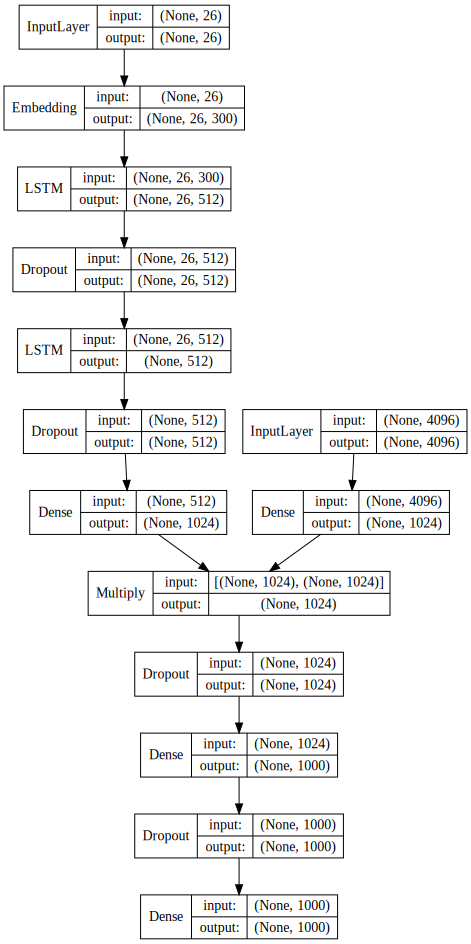

In [5]:
SVG(model_to_dot(m, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

### Training and Validating the Model

To train and validate the model, we define 2 functions, `train` and `val` , which take as input a model. 

In [6]:
from train_val import *

The cell below is just a dummy test that the training is working. 

In [7]:
_, his = train( epoch=1, batch_size=4, data_limit=8, model_obj=m )

Reading Data...
Epoch 1/1
8/8 [==============================] - 3s 427ms/step - loss: 6.9022 - acc: 0.1250


Now we train our basic model from scratch for 100 epochs. The results are summarized by the two charts below. 

What you see from the accuracy chart is that the training set accuracy continues to improve, but the test set accuracy quickly levels off around 44%. This suggests that there is some overfitting of the train set happening, even though our model includes dropout. As discussed in class, the next best approaches would be to apply other regularization techniques, or get more training data. If you let this model continues to 150 epochs, the training set accuracy reaches 99%, with the test set accuracy remaining flat at 44%. 

<img src="./images_for_notebook/vgg_lstm1_accuracy.png">

Interestingly, looking at the loss function, the test set loss has been increasing since about the 20th epoch. There hasn't been much of a loss in accuracy, however. This may mean that the model still outputs the same answer (the same index is still output from `argmax(output_vector)`), but there is less probability on that max value, suggesting the model is less confident. 

<img src ="./images_for_notebook/vgg_lstm1_loss.png">

## Experiments

Having gotten the basic model working and training, we look into ways to improve its performance. 

2. [Swapping out VGG19 encodings for ResNet50 encodings](#resnet)
3. [Using a concatenation of both LSTM layer hidden outputs as part of question embedding](#concat)
3. [Using a Different Loss Function (Soft Cross-Entropy)](#loss_function_mods) ** ---MOST SIGNIFICANT--- **
4. [Swapping out element-wise multiplication for multimodal factorized bilinear pooling](#compact_bilinear)
5. Trying more aggressive dropout and L2 Regularization
6. Swapping out tanh activations for ReLU 

<a id='resnet'></a>
### Changing Out VGG19 for ResNet50

Most best-in-class VQA models (including first place in this year's competition [ [1] ](https://arxiv.org/pdf/1708.02711.pdf)) use ResNet encodings instead of VGG19. However, they generally use ResNet-101 or ResNet-152. 

We, however, decided to try encodings from ResNet50. Relative to VGG19, ResNet50 is far smaller (25.5M params versus 143.6M), which means it should run faster and be less memory intensive. Therefore, if we could even prove similar prediction accuracy with ResNet50, this would be an improvement, since it makes the ultimate model smaller. It was also convenient that Keras has a ResNet50 implementation that can be easily imported. 

We chose the penultimate layer of Resnet50, which consists of a (2048,1) embedding for a given image. Note that this is half the size of the VGG19 embedding, so we had to modify our model to account for this. 

Rather than connect the ResNet50 model to the front end of our existing VQA model, we decided to pre-compute the embeddings to save on future training time. To do this, we had to download all 80K MSCOCO images, run them through ResNet50, and create a new HDF5 dataset of (2048,1) embeddings which could then be fed to our VQA model. The code to do this is under the `Supplementary Code` directory in `create_h5dataset.py` and `create_resnet_embeddings.py`

In [8]:
from resnet_lstm import get_model as resnet_lstm_model

In [9]:
resnet_m = resnet_lstm_model(dropout_rate=0.5)

Creating Model...
Found matrix so no need to recompute!
Creating functional image model using pre-computed embeddings...
Creating functional text model with both layers...
Merging final functional model...
No model weights file specified. Skipping weight load.


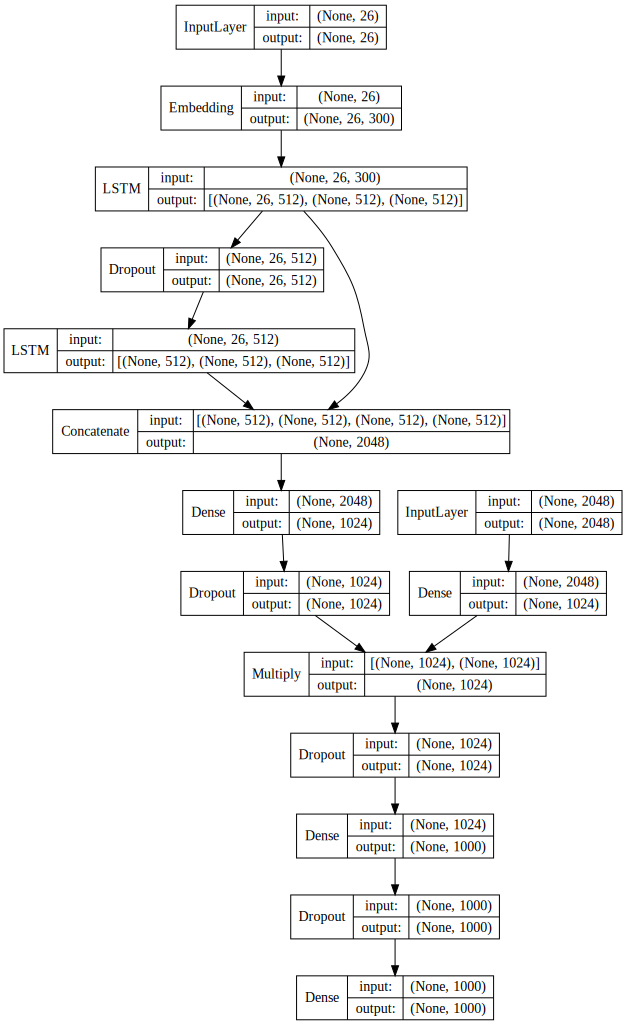

In [10]:
SVG(model_to_dot(resnet_m, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Now a dummy line to test the training function with a resnet model. 

In [11]:
_, his = train( epoch=1, batch_size=4, data_limit=8, model_type="ResNet", model_obj=resnet_m )

Reading Data...
Epoch 1/1
8/8 [==============================] - 4s 509ms/step - loss: 40.8326 - acc: 0.1250


Because of the overfitting we'd seen in the VGG19 model we ran several different flavors of the ResNet50 version that included more or less regularization to study the effects. 
1. No dropout
2. 50% dropout
3. 60% dropout plus L2 regularization

We trained for 100 epochs and saw the following results. On the whole, we did not see much improvement in terms of tes accuracy with ResNet50 across any of the runs. The different regularization settings did not appear to fix the gap in accuracy between test and train sets. Train set accuracy was lower, but there was no corresponding increase in test set accuracy. 

One observation that can be made from the graphs is that the training loss drops most quickly for the model with no dropout, followed by the 50% dropout model, with the 60% dropout + l2 regularization model taking the longest. This is consistent with what we would expect, since these techniques generally make models do worse on the training set.

With the Resnet Model, training the non-dropout model for 100 epochs gets to almost 100% train set accuracy, as mentioned above. 

Resnet No Dropout Model Accuracy | Resnet No Dropout Model Loss
- | - 
<img src = './images_for_notebook/resnet_nodropout_acc.png'> | <img src= './images_for_notebook/resnet_nodropout_loss.png'> 

Resnet 50% Dropout Model Accuracy | Resnet 50% Dropout Model Loss
- | - 
<img src= './images_for_notebook/resnet_50drop_100epoch_acc.png'> | <img src= './images_for_notebook/resnet_50drop_100epoch_loss.png'> 

Resnet 60% Dropout plus L2 Reg Model Accuracy | Resnet 60% Dropout plus L2 Reg Model Loss
- | - 
<img src= './images_for_notebook/resnet_drop_l2reg_accuracy.png'> | <img src= './images_for_notebook/resnet_drop_l2reg_loss.png'> 

<a id='concat'></a>
## Question Embedding Experiments -- Concat vs. Last Layer of LSTM Only

As observed above, the word embeddings taken from the open source code we imported only used the last hidden state output of the LSTM (i.e. output from the second layer). Now we'll fix that and retrain to see if our accuracy is improved by using the cell ('c') and hidden ('h') output of both LSTM hidden layers. This is what the original [VQA paper](https://arxiv.org/pdf/1505.00468v6.pdf) describes doing. 

In [12]:
from vgg19_lstm_concat import get_model as vqa_model_vgg19_lstm_concat

In [13]:
m_concat = vqa_model_vgg19_lstm_concat(dropout_rate=0.5)

Creating Model...
Found matrix so no need to recompute!
Creating functional image model...
Creating functional text model with both layers...
Merging final functional model...
No model weights file specified. Skipping weight load.


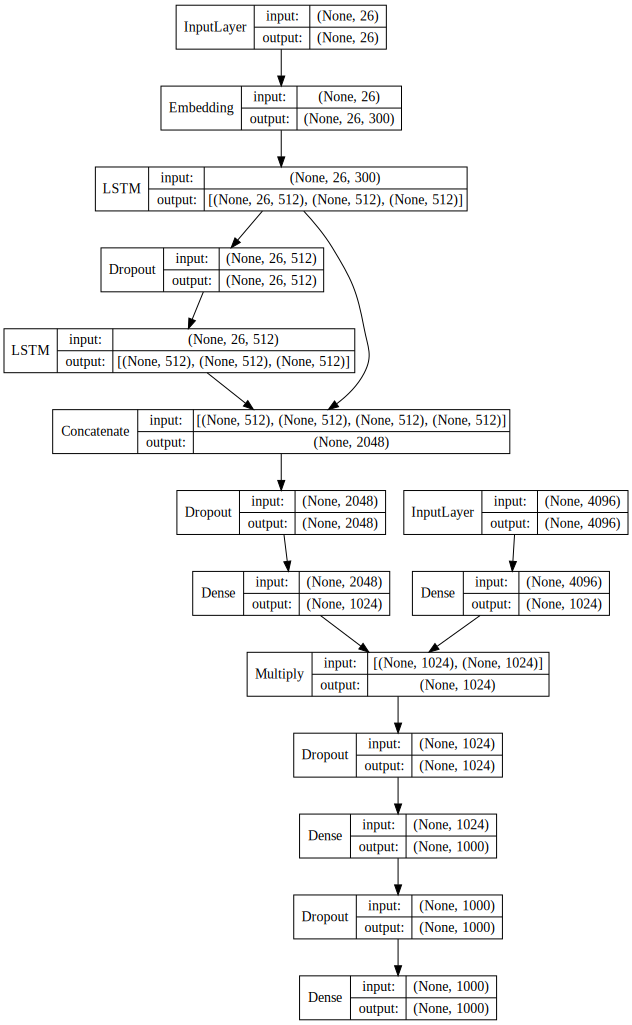

In [14]:
SVG(model_to_dot(m_concat, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

After training, we saw only minor improvements with this approach. If you look at the charts, you'll see that the base model does slightly better than the concat model on the training dataset. After 100 epochs the loss was still falling for both models though, suggesting they'd both probably eventually get to 99% accuracy as was seen before. 

<br>
However, the concat model does slightly better on the test set, exhibiting both smaller loss and slightly better accuracy. It seems it is more robust to overfitting than the base model. 

Accuracy Comparison | Loss Comparison
- | - 
<img src = './images_for_notebook/concat_acc.png'> | <img src= './images_for_notebook/concat_loss.png'> 

<a id='loss_function_mods'></a>

## Loss Function - Soft Cross Entropy Loss vs. Categorical Cross Entropy Loss

Our original model used categorical cross-entropy loss, with the ground-truth answer being a one-hot vector encoding the answer given by the majority of the human respondents polled. However, the VQA metric actually awards partial credit to models that output answers that match any of the ten human respondent answers. Thus, our original model has a disconnect between the loss function and the evaluation metric. 

One of the top performers in this year's VQA challenge sought to address this by proposing a [soft cross entropy loss](https://ilija139.github.io/pub/cvpr2017_vqa.pdf) function. This function calculates a weighted average of all unique ground truth answers given by the 10 human respondents. 



Categorical Cross Entropy | Soft Cross Entropy
- | - 
<img src = './images_for_notebook/categorical_cross_entropy.png'> | <img src= './images_for_notebook/soft_cross_entropy.png'>

While the authors of the paper implemented soft cross entropy loss via modifying their implementation of the default categorical cross entropy loss function, we determined that it is possible to compute the save loss by changing our Y label to a vector of percentages, and using the default categorical cross entropy loss.

Hence, we modified our Y labels to be a vector of the percentage of time that the answer at that index appears in the ten ground truth answers. 

To train with soft cross entropy loss, we pass in `loss_type="soft"` to our training routine.

In [15]:
_, his = train( epoch=1, batch_size=4, data_limit=8, model_type="ResNet", model_obj=resnet_m, loss_type="soft" )

Reading Data...
Epoch 1/1
8/8 [==============================] - 2s 240ms/step - loss: 31.5100 - acc: 0.5000


After training various models using soft cross entropy, we saw that this lead to an 15 ~ 20% increase in accuracy of the given model. Below, we compare the effects of soft cross entropy on the Element-wise Product model with ReLU Activations.

Accuracy Comparison | Loss Comparison
- | - 
<img src = './images_for_notebook/soft_acc.png'> | <img src= './images_for_notebook/soft_loss.png'>

<a id='compact_bilinear'></a>
## Fused MultiModal Compact Bilinear Pooling 

The [second place winner](https://arxiv.org/pdf/1606.01847.pdf) in this year’s VQA challenge implemented a concept known as multimodal compact bilinear pooling. The idea is that using concatenation or elementwise multiplication to combine image and question embeddings (each of which represents information from a different modality, hence the term “multimodal”) may limit model performance. A more sophisticated approach to fusing these two might be necessary.

One option is to instead do an outer product of the image and question embeddings, but this becomes infeasible because of the resulting $N^2$ size matrix is much too big to connect to subsequent dense layers (results in too many model parameters). 

Multimodal compact bilinear pooling is a way to do the outer product and then further compress it. It amounts to a combination of element-wise multiplication, fully connected layers, and sum pooling. 

MultiModal Compact Bilinear Pooling | MCB Algorithm
- | - 
<img src = './images_for_notebook/MCB_diagram.png'> | <img src= './images_for_notebook/MCB_algorithm.png'>

As there were no existing implementations of Compact Bilinear Pooling for keras on Python 3 and using the Tensorflow backend, we implemented it as a custom Keras layer by referencing an exising implementation in [Tensorflow](https://github.com/ronghanghu/tensorflow_compact_bilinear_pooling), and [Keras on Theano](https://libraries.io/github/akshaychawla/keras). The custom Keras layer can be found at `keras_tensorflow_compact_bilinear_pooling.py` is only for Keras on Tensorflow backend.

In [17]:
from mcb_relu import get_model as vqa_model_mcb

In [18]:
m_concat = vqa_model_mcb(dropout_rate=0.5)

Creating Model...
Found matrix so no need to recompute!
Creating functional image model...
Creating functional text model with both layers...
Merging final functional model...
No model weights file specified. Skipping weight load.


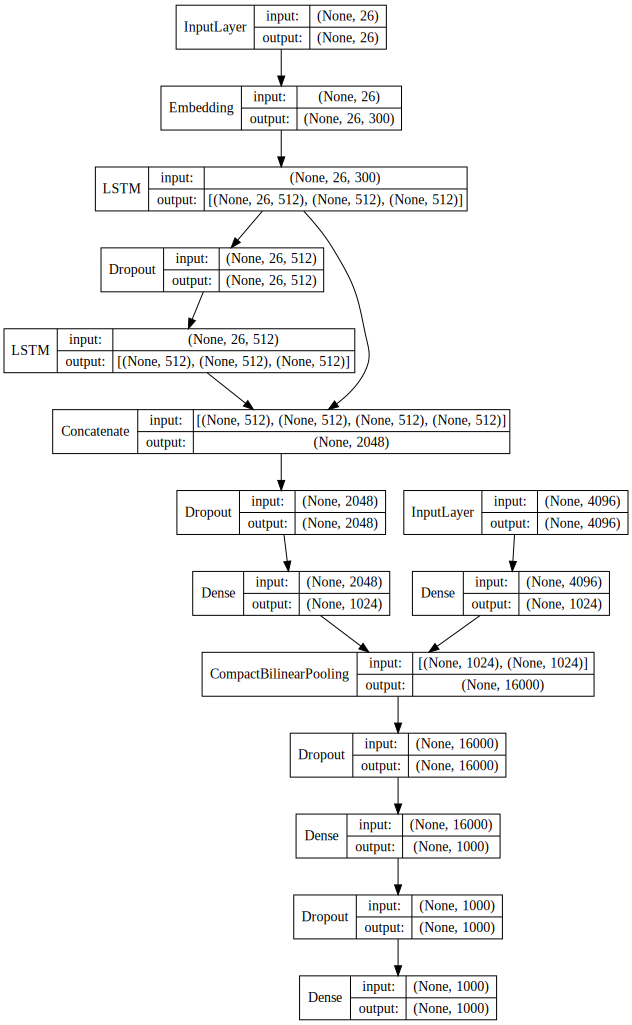

In [19]:
SVG(model_to_dot(m_concat, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

The second place paper observed a 1.3% increrase in validation accuracy from changing the element-wise multiplication layer to multimodal bilinear pooling, we observed comparable results with ReLU activations, and a significant decrease in model accuracy when using Tanh activation.  

See below for accuracy and loss comparison between Element-wise Multiplication and MCB models both using regular categorical cross entropy and RelU activation.

Accuracy Comparison | Loss Comparison
- | - 
<img src = './images_for_notebook/mcb_acc.png'> | <img src= './images_for_notebook/mcb_loss.png'>

## Final Results

The final results are summarized in the table below. Overall, our best model performance (highlighted in green) was the VGG based model with soft cross entropy loss and ReLU activations (and dropout of 0.5 during training).  <br>

**Top answer accuracy** is the percentage of the time that the model output the most common answer given by the 10 human respondents. 

**VQA Evaluation Accuracy** gives partial credit for cases where the model outputs an answer that was given by at least 1 human responded. 

**Top 10 Answer Accuracy** is the percentage of the time that the model output an answer that matched with at least 1 of the human generated answers. 

For reference, the top 3 overall model accuracies from the [2016 VQA v1.0 challenge](http://www.visualqa.org/roe.html) were 66.9%, 64.89%, and 63.97%. These 3 reported accuracies would most closely match our **VQA Evaluation Accuracy** statistic, although there is a slight difference in the formula used. (In the case of the VQA challenge, model ["accuracies are averaged over all 10 choose 9 sets of human annotators"](http://www.visualqa.org/evaluation.html)). More importantly, **these accuracies are on a different dataset** (ours are using vqa v1.0 "validation" and these used vqa v1.0 "testing"). 


![Model Performance](./images_for_notebook/final_results.png)

## Other Work

A substantial amount of time was invested in creating a model that implemented attention but to little avail. 

The team did succeed in defining the attention architecture proposed in this [paper](https://arxiv.org/pdf/1708.02711.pdf), the VQA v2.0 winner. Generally, the architecture involves looked at the 2048 channel feature vector for a (7,7) grid over the image. For the 49 grid squares, the 2048 channel embedding is concatenated with the question embedding out of the LSTM. The result is then passed through several fully connected layers to create an attention vector of length 49. That 49 element attention vector is then multiplied with the (49,2048) original image embedding to return a (1,2048) image embedding. 

This image embedding is shrunk to 512 elements via a dense layer. It is then combined with the original question embedding via elementwise multiplication and passed through dense layers, retaining pretty much the same architecture as in our original model. 

The main challenge run into was actually in creating the (7,7,2048) size embedding for each image in the dataset. This involved running all 80k images in the dataset through ResNet50 and extracting information from the appropriate layer. However, once generated, this resulted in a dataset that was prohibitively large (>40GB). 

Because of how large the dataset was, it could no longer be completely loaded into memory, which meant we had to write a DataGenerator function to batch the loading of the dataset. 

### Small Scale Testing 
A better approach would have been to create a smaller subset of the dataset just to check if the model was working. Eventually, we realized this, and created an 8600 element dataset of 49x2048 resnet image embeddings (flattened from the 7x7x2048 output) and questions, and tested the model to see if it could fit this data. 


In [20]:
from attention_model import get_model_w_attn

In [21]:
m_w_attn = get_model_w_attn()

Found matrix so no need to recompute!
Creating functional text model...
Creating functional image model...


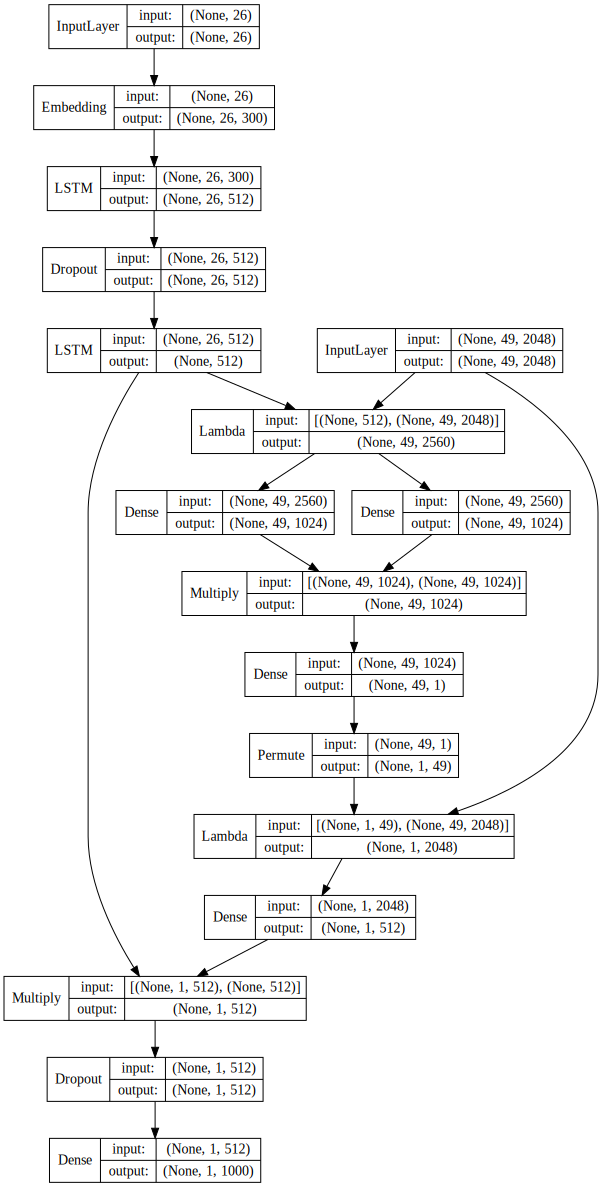

In [22]:
SVG(model_to_dot(m_w_attn, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Given our 8600 question-answer pairs, we decided to use 90% of the data for training and 10% for validation (using the validation_split knob in the model.fit method). Using our original binary cross entropy loss function, we trained for 100 epochs. The results are summarized below. 

Accuracy Comparison | Loss Comparison
- | - 
<img src = './images_for_notebook/model_acc_wattn.png'> | <img src= './images_for_notebook/model_loss_wattn.png'>

The positive note about both of these graphs is that we see the training set loss decreasing (and the accuracy increasing), which means our model is able to fit the data. This is the first step in validating our attention model architecture. 

As in our baseline model runs (before attention was added), we still see a significant delta between train and test set performance. The model above did not use dropout, so we tried one more run with 50% dropout added after the dense layers and the LSTM layers, but the results were basically identical. 

The good news with this test though is that it suggests it is worth pursuing training this model on the full dataset. We might also want to pull in some of the modifications we made in our baseline model (especially the soft cross entropy loss function and ReLU activations). 

## Extensions

The most logical extension for this project is to continue work on implementing the attention model begun in the "Other Work" section. All models on the leaderboard for the VQA challenge implement some form of attention. Once a basic attention model has been tuned, we could experiment with being smarter about the image regions considered for attention. Rather than looking at attention for a 7x7 square grid superimposed on the image, we could create an attention vector for a set of boxes that we know identify particular objects/regions of interest in the image. One might imagine taking the objects localized by a YOLO Model and using those as the inputs to the attention model. 

As part of the attention model development, it would be interesting to do better visualization of the model's performance. Specifically, we could look at what regions in the image were most useful to the network for answering the question. We could also visualize which words were the most important ones in the question. 

## Demo

We show how our model can be extended to try arbitrary jpeg and question combinations. We load our best in class model for testing (VGG19 + soft cross entropy loss) and then call our function `test_vqa_model`. 

`test_vqa_model` takes a JPEG and string as inputs. It creates the question embedding (300x26; 300 element vector per word; 26 word long questions), and the 4096 JPEG embedding from VGG19. Then it feeds both of these to our best in class model, which we load below. 

In [23]:
from demo import test_vqa_model
from IPython.display import Image
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

In [24]:
def vqa_eval_accuracy(y_true, y_pred):
    trues = K.clip(y_true, min_value=0, max_value=0.3) / 0.3
    preds = K.argmax(y_pred, axis=-1)
    return K.map_fn(gather, [trues, preds], dtype=tf.float32)

def gather(x):
    true, pred = x
    return K.gather(true, pred)

vqa_mod = load_model("../../finalized_models/model_ELEMULT_RELU_SOFTY_weights.h5", custom_objects={'vqa_eval_accuracy': vqa_eval_accuracy})

We picked a random [image](http://chinenyeugonna.com/2016/05/17/best-spots-for-pizza-in-lagos/) off the internet, but if you wanted to try out the model, just change the `my_sample_question` and `my_test_img` variables.  

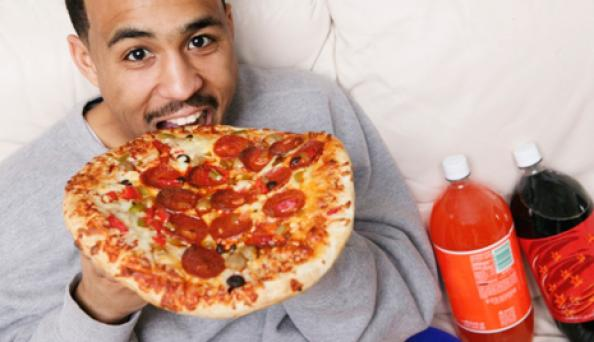

In [25]:
my_sample_question = "What is the man eating?"
my_test_img = "./images_for_notebook/pizza_man.jpg"

Image(filename=my_test_img) 

In [26]:
labels = test_vqa_model(my_sample_question, my_test_img, vqa_mod)

Question: What is the man eating?
Answer: pizza


## Contributions

__Stephanie Dong:__ Stephanie worked on experiments comparing element-wise product, vector concatination, and multimodal compact bilinear pooling as the merge layer between image and question embeddings, including implementing a custom keras layer for compact bilinear pooling. In addition, she implemented label generation from question-image annotations to produce weighted labels for soft cross entropy loss. Lastly, she contributed to the project infrastucture, including plotting and saving training history over disjoint sessions, and the final project writeup.

__Alona King:__ Alona researched various infrastructures to for the project, worked on the loss function for the infrastructure we chose, and created the final presentation for the project.

__Jennifer Villa:__ Jennifer worked on the experiments contrasting concatenation with using the last LSTM hidden state for the question embeddings. She also generated the ResNet50 embeddings for the dataset images, and ran the experiments comparing ResNet50 image embeddings with those from VGG19. In addition, she implemented the attention model and generated the new set of ResNet50 embeddings required (from an earlier layer). Lastly, she contributed to the final project writeup, including developing the demo portion. 